In [23]:
import mlflow
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

## Get Data
This Data shows the graduation percentage aggregated to varying levels ranging from school,county,District and State in New York.

In [19]:
df = pd.read_csv('GRAD_RATE_AND_OUTCOMES_2024.csv')

C:\Users\koryi\AppData\Local\Temp\ipykernel_37376\1476713966.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('GRAD_RATE_AND_OUTCOMES_2024.csv')


In [20]:
df.aggregation_type.value_counts()


aggregation_type
School                    140726
District                   73120
County                      8184
Need/Resource Category       986
Statewide                    144
Name: count, dtype: int64

In [21]:
#Data Aggregation type essentially makes this five different datasets with redundant information that aggregates to different grains. We will only use the lowest level (school) for this analysis.

school = df[df['aggregation_type'] == 'School']
school.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140726 entries, 82434 to 223159
Data columns (total 36 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   report_school_year          140726 non-null  object 
 1   aggregation_index           140726 non-null  int64  
 2   aggregation_type            140726 non-null  object 
 3   INSTITUTION_ID              140726 non-null  float64
 4   aggregation_code            140726 non-null  int64  
 5   aggregation_name            140726 non-null  object 
 6   lea_beds                    140726 non-null  float64
 7   lea_name                    140726 non-null  object 
 8   nrc_code                    140726 non-null  float64
 9   nrc_desc                    140726 non-null  object 
 10  county_code                 140726 non-null  float64
 11  county_name                 140726 non-null  object 
 12  nyc_ind                     140726 non-null  float64
 13  boces_code     

Reviewing the data dictionary there is a lot that can be derived from demographic data on each instituion as well. New York provides this ina Cognos report publicly available.

https://eservices.nysed.gov/sedreports/

In [22]:
#Data pulled from NY Cognos reports regarding instituition details

Institution = pd.read_csv('Instituition_info.csv', encoding='utf-16')

## Exploratory Data Analysis/Cleaning

First We will join institution demographic data to get the Institution Type description then do some Exploratory Data Analysis to see if there are any preliminary insights to draw and also help us with Feature Selection.

In [24]:
school = school.merge(Institution[['Institution ID','INST Sub Type Description']],
                      how='left',
                      left_on= 'INSTITUTION_ID',
                      right_on= 'Institution ID',
                      )

In [25]:
#Type Transformations
school = school[school['dropout_pct'] != '-'].copy()
school['dropout_pct'] = school['dropout_pct'].str.replace('%','').astype('float')

In [26]:
school.nrc_desc.value_counts()

nrc_desc
NYC                                      39882
Average Needs                            26242
Low Needs                                11008
Rural High Needs                         10474
Charters                                  6994
Urban-Suburban High Needs                 4238
Buffalo  Rochester  Yonkers  Syracuse     3870
Name: count, dtype: int64

In [27]:
school['INST Sub Type Description'].value_counts()

INST Sub Type Description
PUBLIC SCHOOL CITY                      48610
PUBLIC SCHOOL INDEPENDENT CENTRAL       17602
PUBLIC SCHOOL CENTRAL                   17032
PUBLIC SCHOOL INDEPENDENT UNION FREE     8126
CHARTER SCHOOL                           6994
PUBLIC SCHOOL UNION FREE                 2666
PUBLIC SCHOOL CENTRAL HIGH SCHOOL         982
PUBLIC SCHOOL CITY CENTRAL                520
PUBLIC SCHOOL SPECIAL ACT                 176
Name: count, dtype: int64

In [28]:
drouput_by_subgroup = school.groupby('subgroup_name')['dropout_pct'].mean().sort_values().reset_index()
dropout_by_nrc = school.groupby('nrc_desc')['dropout_pct'].mean().sort_values().reset_index()
dropout_by_subtype = school.groupby('INST Sub Type Description')['dropout_pct'].mean().sort_values().reset_index()

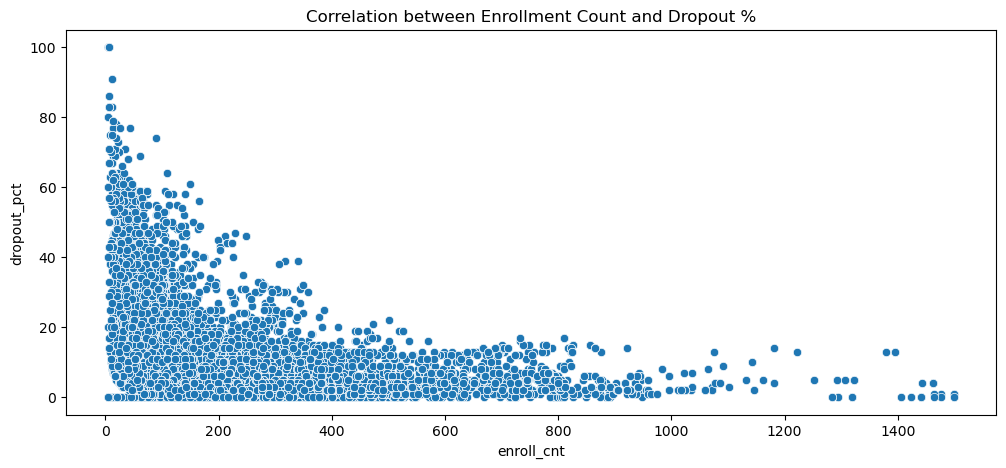

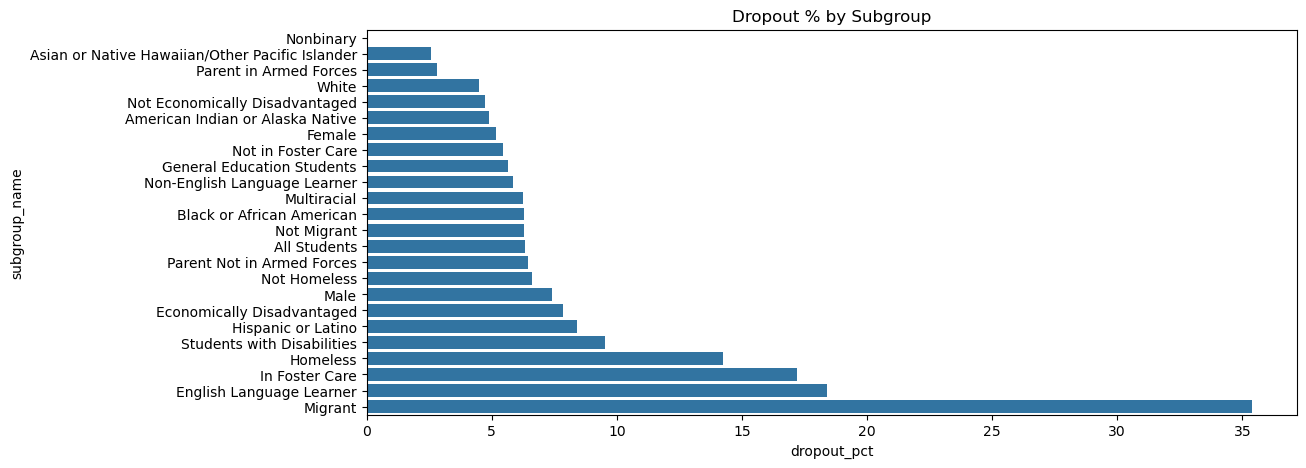

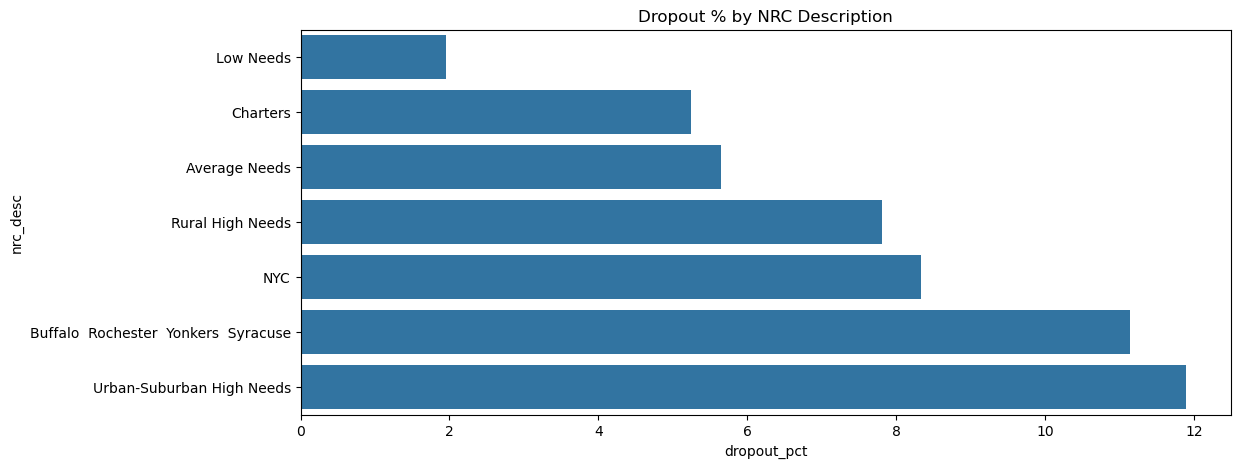

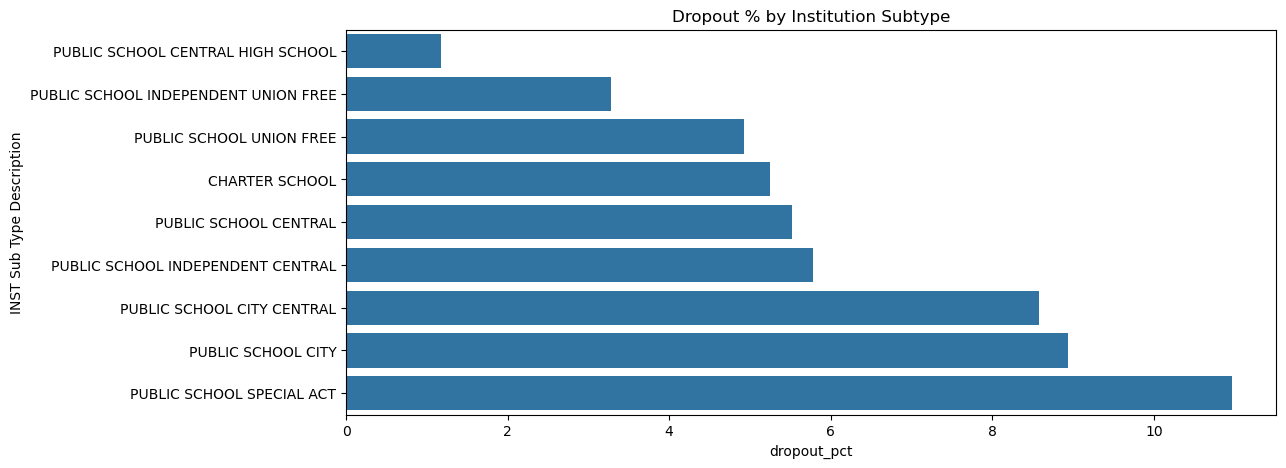

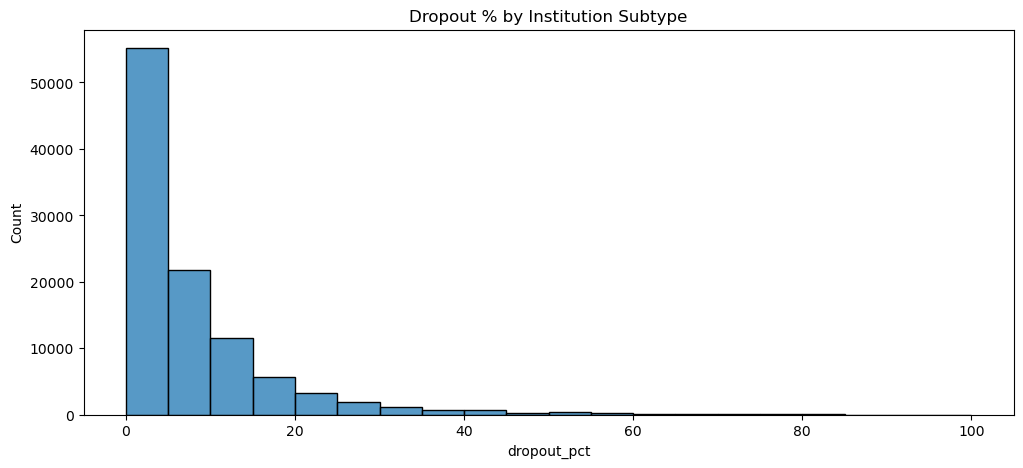

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))
sns.scatterplot(data=school, y='dropout_pct', x='enroll_cnt')
plt.title('Correlation between Enrollment Count and Dropout %')
plt.show()

plt.figure(figsize=(12, 5))
sns.barplot(data=drouput_by_subgroup, x='dropout_pct', y='subgroup_name')
plt.title('Dropout % by Subgroup')
plt.show()

plt.figure(figsize=(12, 5))
sns.barplot(data=dropout_by_nrc, x='dropout_pct', y='nrc_desc')
plt.title('Dropout % by NRC Description')
plt.show()

plt.figure(figsize=(12, 5))
sns.barplot(data=dropout_by_subtype, x='dropout_pct', y='INST Sub Type Description')
plt.title('Dropout % by Institution Subtype')
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(school, x='dropout_pct', bins=20)
plt.title('Dropout % by Institution Subtype')
plt.show()


In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

mldf = school[['subgroup_name','enroll_cnt','nrc_desc','INST Sub Type Description','dropout_pct']]

x = mldf[['subgroup_name','enroll_cnt','nrc_desc','INST Sub Type Description']]
y = mldf['dropout_pct']

cat_cols = ['subgroup_name','nrc_desc','INST Sub Type Description']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat',OneHotEncoder(handle_unknown='ignore', sparse_output=False),cat_cols)
    ]
)

x_array = preprocessor.fit_transform(x)
encoded_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)

x= pd.DataFrame(x_array, columns=encoded_cols)


In [31]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size= .2, random_state= 42)

## Lin Reg

In [ ]:
from sklearn.linear_model import LinearRegression
from dmba import regressionSummary
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

lr = LinearRegression()

lr.fit(xtrain, ytrain)
lr_preds = lr.predict(xtest)

print(regressionSummary(ytest, lr_preds))
print(lr.score(xtrain, ytrain))

lr_metrics = {
        "MAE": mean_absolute_error(ytest, lr_preds),
        "MSE": mean_squared_error(ytest, lr_preds),
        "RMSE": mean_squared_error(ytest, lr_preds, squared=False),
        "R2": r2_score(ytest, lr_preds),
        "ME": np.mean(ytest - lr_preds),
    }


Regression statistics

               Mean Error (ME) : 0.0129
Root Mean Squared Error (RMSE) : 8.4683
     Mean Absolute Error (MAE) : 5.5828
None
0.15273846086538578


In [33]:
residuals_df = pd.DataFrame({'Actual':ytest,
                    'Predicitions': lr_preds.round(2),
                    'Residuals': (ytest-lr_preds).round(2)})
residuals_df

,Actual,Predicitions,Residuals
1534,2.0,4.52,-2.52
18507,1.0,6.00,-5.00
56281,23.0,8.51,14.49
101069,1.0,5.80,-4.80
39612,17.0,10.94,6.06
...,...,...,...
57231,0.0,5.69,-5.69
57823,1.0,5.02,-4.02
120590,0.0,7.23,-7.23
103965,2.0,7.26,-5.26


In [ ]:
import mlflow.sklearn

#Starting our experiment in MLFlow so we can easily compare models and imitate 

mlflow.set_experiment('Graduation Dropout Prediction')
mlflow.set_tracking_uri('http://127.0.0.1:5000')

with mlflow.start_run(run_name= 'Linear Regression'):
    mlflow.log_param('features',','.join(cat_cols))
    mlflow.log_metrics(lr_metrics)

2025/06/25 19:20:36 INFO mlflow.tracking.fluent: Experiment with name 'Graduation Dropout Prediction' does not exist. Creating a new experiment.
c:\Users\koryi\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


🏃 View run Linear Regression at: http://127.0.0.1:5000/#/experiments/202933434321497400/runs/7dba04851f60457190ea4116aad9a893
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/202933434321497400


## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()

dt.fit(xtrain, ytrain)
dt_preds = dt.predict(xtest)

print(regressionSummary(ytest, dt_preds))

dt_metrics = {
        "MAE": mean_absolute_error(ytest, lr_preds),
        "MSE": mean_squared_error(ytest, lr_preds),
        "RMSE": mean_squared_error(ytest, lr_preds, squared=False),
        "R2": r2_score(ytest, lr_preds),
        "ME": np.mean(ytest - lr_preds)
        }



Regression statistics

               Mean Error (ME) : 0.0009
Root Mean Squared Error (RMSE) : 8.3768
     Mean Absolute Error (MAE) : 5.4732
None
